In [4]:

import os
import glob
import pandas as pd
import re
import geopandas as gpd
import json

from bokeh.io import output_notebook, show,curdoc
from bokeh.plotting import figure, output_file, save
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, Slider, HoverTool
from bokeh.palettes import brewer
from bokeh.layouts import widgetbox, row, column

os.chdir(r'C:\Users\abibeka\OneDrive - Kittelson & Associates, Inc\Documents\HSIP\Crash Analsys - Apoorba')
os.getcwd()

'C:\\Users\\abibeka\\OneDrive - Kittelson & Associates, Inc\\Documents\\HSIP\\Crash Analsys - Apoorba'

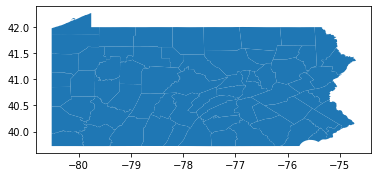

In [5]:
#*****************************************************************************************************************************
# Read the Data
#*****************************************************************************************************************************
Wb_Name = 'Fatality_Statistics_Processed'
x1 = pd.ExcelFile(Wb_Name+'.xlsx')
x1.sheet_names
df = x1.parse('Alcohol-Related')

# Read District data
x3 = pd.ExcelFile('RawData/County_District_KeyMap.xlsx')
DistrictKeys = x3.parse('Data')


# Read the County and District Shape Files
Countyshapefile = 'PennDOT-CountyDistrictShp/County_Boundary.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(Countyshapefile)[['COUNTY_NAM', 'DISTRICT_N','PLANNING_P', 'geometry']]
gdf.head()
gdf.plot()
gdf.loc[:,'COUNTY_NAM'] = gdf.COUNTY_NAM.str.capitalize()
gdf.loc[:,'COUNTY_NAM'] = gdf.COUNTY_NAM.str.capitalize()
gdf.loc[:,'COUNTY_NAM']= gdf.loc[:,'COUNTY_NAM'].str.capitalize().str.strip().str.replace('Mckean','McKean')
gdf.rename(columns = {'COUNTY_NAM': 'CountyNm'},inplace=True)
df.columns
df_2016  = df[['CountyNm',2016, 'District','TotalLinearMiles','TotalDVMT']]


In [7]:
YearCols = df.columns.tolist()
YearCols.remove('CountyNm')
YearCols.remove('CrashCategory')
YearCols.remove('District')
YearCols.remove('TotalLinearMiles')
YearCols.remove('TotalDVMT')
NewYearCols = []
for i in YearCols:
    df.rename(columns = {i:"Yr-{}".format(i)},inplace=True)
    NewYearCols.append("Yr-{}".format(i))

df1 = pd.wide_to_long(df,'Yr', i='CountyNm',
                j='year',sep = '-')
df1.rename(columns= {'Yr':"Fatalities"},inplace=True)
df1.reset_index(inplace=True)
def json_data(selectedYear):
    yr = selectedYear
    df_yr = df1[df1['year'] == yr]
    merged = gdf.merge(df_yr, left_on = 'CountyNm', right_on = 'CountyNm', how = 'left')
    merged.fillna('No data', inplace = True)
    merged_json = json.loads(merged.to_json())
    json_data = json.dumps(merged_json)
    return json_data
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data(2015))
#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40, nan_color = '#d9d9d9')
#Define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}
#Add hover tool
hover = HoverTool(tooltips = [ ('Country/region','@CountyNm'),('Fatalities', '@Fatalities')])


#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff= 8,width = 600, height = 30,
border_line_color=None,location = (0,0), orientation = 'horizontal') #, major_label_overrides = tick_labels


#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 30,
                     border_line_color=None,location = (0,0), orientation = 'horizontal') #, major_label_overrides = tick_labels)
#Create figure object.
#Create figure object.
p = figure(title = 'Alcohol-Related Fatalities, 2016', plot_height = 700 , plot_width = 1000, 
           toolbar_location = None,outline_line_width=0,outline_line_alpha=0, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Fatalities', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify layout
p.add_layout(color_bar, 'below')
# Define the callback function: update_plot
def update_plot(attr, old, new):
    yr = slider.value
    new_data = json_data(yr)
    geosource.geojson = new_data
    p.title.text = 'Share of adults who are obese, %d' %yr
    
# Make a slider object: slider 
slider = Slider(title = 'Year',start = 1999, end = 2016, step = 1, value = 2016)
slider.on_change('value', update_plot)
# Make a column layout of widgetbox(slider) and plot, and add it to the current document
layout = column(p,widgetbox(slider))
curdoc().add_root(layout)

In [10]:
output_notebook()
show(layout)


Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html

